In [133]:
import rasterio as rio
import matplotlib.pyplot as plt 
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'



In [2]:
run ../util/setupConsole

In [3]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'

In [4]:
# load the sacks crop calendars

sacksMaizeStart = np.genfromtxt('%s/sacks/sacks-planting-end-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeStart[sacksMaizeStart<0] = np.nan
sacksMaizeEnd = np.genfromtxt('%s/sacks/sacks-harvest-start-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeEnd[sacksMaizeEnd<0] = np.nan

sacksMaizeStart = np.roll(sacksMaizeStart, int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeEnd = np.roll(sacksMaizeEnd, int(sacksMaizeEnd.shape[1]/2), axis=1)


In [5]:
# calculate gdd/kdd from cpc temperature data

if os.path.isfile('%s/kdd-cpc-%s.dat'%(dataDirDiscovery, crop)) and os.path.isfile('%s/gdd-cpc-%s.dat'%(dataDirDiscovery, crop)):
    with gzip.open('%s/kdd-cpc-%s.dat'%(dataDirDiscovery, crop), 'rb') as f:
        kdd = pickle.load(f)

    with gzip.open('%s/gdd-cpc-%s.dat'%(dataDirDiscovery, crop), 'rb') as f:
        gdd = pickle.load(f)
    
    with gzip.open('%s/gdd-kdd-lat-cpc.dat'%dataDirDiscovery, 'rb') as f:
        lat = pickle.load(f)
    
    with gzip.open('%s/gdd-kdd-lon-cpc.dat'%dataDirDiscovery, 'rb') as f:
        lon = pickle.load(f)
else:
    gdd = np.zeros([360, 720, len(range(1981, 2011+1))])
    kdd = np.zeros([360, 720, len(range(1981, 2011+1))])

    for y, year in enumerate(range(1981, 2011+1)):
        print('processing year %d...'%year)

        dsMax = xr.open_dataset('/dartfs-hpc/rc/lab/C/CMIG/CPC/tmax/tmax.%d.nc'%year, decode_cf=False)
        dsMax.load()

        dims = dsMax.dims
        startingDate = datetime.datetime(1900, 1, 1, 0, 0, 0)
        tDt = []

        for curTTime in dsMax.time:
            delta = datetime.timedelta(hours=int(curTTime.values))
            tDt.append(startingDate + delta)
        dsMax['time'] = tDt

        dsMin = xr.open_dataset('/dartfs-hpc/rc/lab/C/CMIG/CPC/tmin/tmin.%d.nc'%year, decode_cf=False)
        dsMin.load()

        dims = dsMin.dims
        startingDate = datetime.datetime(1900, 1, 1, 0, 0, 0)
        tDt = []

        for curTTime in dsMin.time:
            delta = datetime.timedelta(hours=int(curTTime.values))
            tDt.append(startingDate + delta)
        dsMin['time'] = tDt

        for xlat in range(len(dsMax.lat)):
            for ylon in range(len(dsMax.lon)):
                if ~np.isnan(sacksMaizeStart[xlat,ylon]) and ~np.isnan(sacksMaizeEnd[xlat,ylon]):
                    curTmax = dsMax.tmax[int(sacksMaizeStart[xlat, ylon]):int(sacksMaizeEnd[xlat, ylon]), xlat, ylon]
                    curTmin = dsMin.tmin[int(sacksMaizeStart[xlat, ylon]):int(sacksMaizeEnd[xlat, ylon]), xlat, ylon]

                    curYearGdd = (curTmax.where(curTmax > t_low) + curTmin.where(curTmin > t_low))/2-t_low
                    curYearGdd = curYearGdd.sum(dim='time')

                    gdd[xlat, ylon, y] = curYearGdd.values

                    curYearKdd = curTmax.where(curTmax > t_high)-t_high
                    curYearKdd = curYearKdd.sum(dim='time')

                    kdd[xlat, ylon, y] = curYearKdd.values

    with gzip.open('%s/kdd-cpc.dat'%dataDirDiscovery, 'wb') as f:
        pickle.dump(kdd, f)

    with gzip.open('%s/gdd-cpc.dat'%dataDirDiscovery, 'wb') as f:
        pickle.dump(gdd, f)

    with gzip.open('%s/gdd-kdd-lat-cpc.dat'%dataDirDiscovery, 'wb') as f:
        pickle.dump(dsMax.lat.values, f)

    with gzip.open('%s/gdd-kdd-lon-cpc.dat'%dataDirDiscovery, 'wb') as f:
        pickle.dump(dsMax.lon.values, f)

In [6]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data

if os.path.isfile('%s/kdd-cpc-trends-%s.dat'%(dataDirDiscovery, crop)) and os.path.isfile('%s/gdd-cpc-trends-%s.dat'%(dataDirDiscovery, crop)):
    with gzip.open('%s/kdd-cpc-trends-%s.dat'%(dataDirDiscovery, crop), 'rb') as f:
        kddTrends = pickle.load(f)

    with gzip.open('%s/gdd-cpc-trends-%s.dat'%(dataDirDiscovery, crop), 'rb') as f:
        gddTrends = pickle.load(f)
else:
    gddTrends = np.full([360, 720], np.nan)
    kddTrends = np.full([360, 720], np.nan)

    for x in range(gddTrends.shape[0]):
        for y in range(gddTrends.shape[1]):
            nn = np.where(~np.isnan(gdd[x, y, :]))[0]
            if len(nn) == gdd.shape[2]:
                X = sm.add_constant(range(gdd.shape[2]))
                mdl = sm.OLS(gdd[x, y, :], X).fit()
                gddTrends[x, y] = mdl.params[1]

            nn = np.where(~np.isnan(kdd[x, y, :]))[0]
            if len(nn) == kdd.shape[2]:
                X = sm.add_constant(range(kdd.shape[2]))
                mdl = sm.OLS(kdd[x, y, :], X).fit()
                kddTrends[x, y] = mdl.params[1]

    # if a grid cell has no gdd/kdds, trend will be exactly 0 - set to nan
    kddTrends[kddTrends == 0] = np.nan
    gddTrends[gddTrends == 0] = np.nan
    
    with gzip.open('%s/kdd-cpc-trends-%s.dat'%(dataDirDiscovery, crop), 'wb') as f:
        pickle.dump(kddTrends, f)

    with gzip.open('%s/gdd-cpc-trends-%s.dat'%(dataDirDiscovery, crop), 'wb') as f:
        pickle.dump(gddTrends, f)


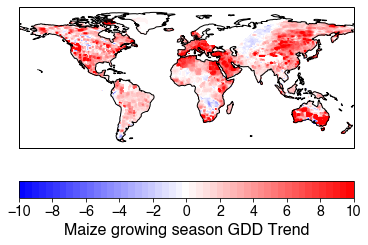

In [7]:
cRange=[-10, 10]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(gddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season GDD Trend'%crop)
ax.coastlines()

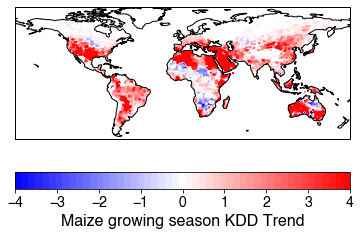

In [8]:
cRange=[-4, 4]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [58]:
# load crop yield trends from iizumi data

maize = np.zeros([360, 720, len(range(1981, 2011+1))])
maizeTrends = np.zeros([360, 720])

rice = np.zeros([360, 720, len(range(1981, 2011+1))])
riceTrends = np.zeros([360, 720])

soybean = np.zeros([360, 720, len(range(1981, 2011+1))])
soybeanTrends = np.zeros([360, 720])

wheat = np.zeros([360, 720, len(range(1981, 2011+1))])
wheatTrends = np.zeros([360, 720])

for year in range(1981, 2011+1):
    maizeNc = xr.open_dataset('%s/iizumi/maize/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    maizeNc.load()
    maizeNc = maizeNc.rename({'var':'maize_yield'})
    maize[:, :, year-1981] = np.flipud(maizeNc.maize_yield.values)
    
    soybeanNc = xr.open_dataset('%s/iizumi/soybean/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    soybeanNc.load()
    soybeanNc = soybeanNc.rename({'var':'soybean_yield'})
    soybean[:, :, year-1981] = np.flipud(soybeanNc.soybean_yield.values)
    
    riceNc = xr.open_dataset('%s/iizumi/rice/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    riceNc.load()
    riceNc = riceNc.rename({'var':'rice_yield'})
    rice[:, :, year-1981] = np.flipud(riceNc.rice_yield.values)
    
    wheatNc = xr.open_dataset('%s/iizumi/wheat/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    wheatNc.load()
    wheatNc = wheatNc.rename({'var':'wheat_yield'})
    wheat[:, :, year-1981] = np.flipud(wheatNc.wheat_yield.values)

maize[maize < 0] = np.nan
soybean[soybean < 0] = np.nan
rice[rice < 0] = np.nan
wheat[wheat < 0] = np.nan


In [128]:
maizeDetrend = np.full(maize.shape, np.nan)
kddDetrend = np.full(kdd.shape, np.nan)
gddDetrend = np.full(gdd.shape, np.nan)

for xlat in range(maize.shape[0]):
    for ylon in range(maize.shape[1]):
        nn = np.where((~np.isnan(maize[xlat, ylon, :])) & (~np.isnan(kdd[xlat, ylon, :])) & (~np.isnan(gdd[xlat, ylon, :])))[0]
        if len(nn) > 10:
            maizeDetrend[xlat, ylon, nn] = scipy.signal.detrend(maize[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(maize[xlat, ylon, nn]))
            gddDetrend[xlat, ylon, nn] = scipy.signal.detrend(gdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(gdd[xlat, ylon, nn]))
            kddDetrend[xlat, ylon, nn] = scipy.signal.detrend(kdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(kdd[xlat, ylon, nn]))
        

In [59]:
# calculate trends in crop yields

for xlat in range(maize.shape[0]):
    for ylon in range(maize.shape[1]):
        nn = np.where(~np.isnan(maize[xlat, ylon, :]))[0]
        if nn.shape[0] > 10:#== maize.shape[2]:
            X = sm.add_constant(range(nn.size))
            mdl = sm.OLS(maize[xlat, ylon, nn], X).fit()
            maizeTrends[xlat, ylon] = mdl.params[1]
        
        nn = np.where(~np.isnan(soybean[xlat, ylon, :]))[0]
        if nn.shape[0] == soybean.shape[2]:
            X = sm.add_constant(range(soybean.shape[2]))
            mdl = sm.OLS(soybean[xlat, ylon, :], X).fit()
            soybeanTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(rice[xlat, ylon, :]))[0]
        if nn.shape[0] == rice.shape[2]:
            X = sm.add_constant(range(rice.shape[2]))
            mdl = sm.OLS(rice[xlat, ylon, :], X).fit()
            riceTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(wheat[xlat, ylon, :]))[0]
        if nn.shape[0] == wheat.shape[2]:
            X = sm.add_constant(range(wheat.shape[2]))
            mdl = sm.OLS(wheat[xlat, ylon, :], X).fit()
            wheatTrends[xlat, ylon] = mdl.params[1]

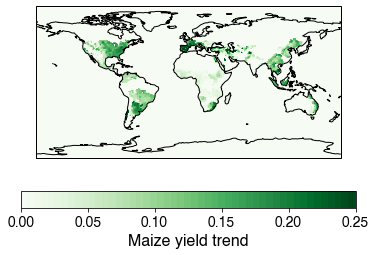

In [60]:
cRange=[0, .25]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(maizeTrends, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .05))
cbar.set_label('%s yield trend'%crop)
ax.coastlines()

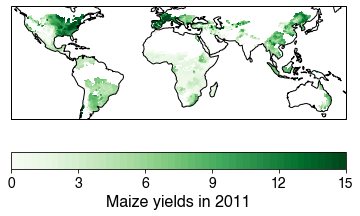

In [61]:
cRange=[0, 15]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(maize[:,:,-1], cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 3))
cbar.set_label('Maize yields in 2011')
ax.coastlines()

In [100]:
gddMaizeCoef = np.full([maize.shape[0], maize.shape[1]], np.nan)
kddMaizeCoef = np.full([maize.shape[0], maize.shape[1]], np.nan)

for xlat in range(maize.shape[0]):
    if xlat%20 == 0: print(xlat)
    for ylon in range(maize.shape[1]):
        nn = np.where((~np.isnan(maizeDetrend[xlat, ylon, :])) & (~np.isnan(gddDetrend[xlat, ylon, :])) & (~np.isnan(kddDetrend[xlat, ylon, :])))[0]
        
        if len(nn) > 10:
            data = {'GDD':gddDetrend[xlat, ylon, nn], 'KDD':kddDetrend[xlat, ylon, nn], \
                    'Yield':maizeDetrend[xlat, ylon, nn]}
            df = pd.DataFrame(data, \
                              columns=['GDD', 'KDD', \
                                       'Yield'])
            mdl = smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
            gddMaizeCoef[xlat, ylon] = mdl.params['GDD']
            kddMaizeCoef[xlat, ylon] = mdl.params['KDD']
        

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340


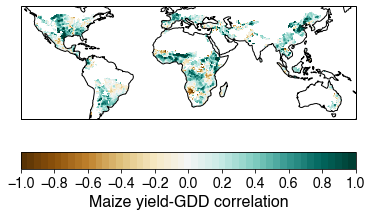

In [101]:
cRange=[-1, 1]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(gddMaizeCoef, cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .2))
cbar.set_label('%s yield-GDD correlation'%crop)
ax.coastlines()

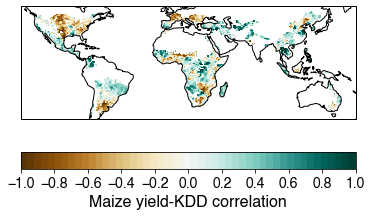

In [102]:
cRange=[-1, 1]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(kddMaizeCoef, cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .2))
cbar.set_label('%s yield-KDD correlation'%crop)
ax.coastlines()

In [183]:
maizeDetrend1d = np.reshape(maizeDetrend, [maizeDetrend.size])
gddDetrend1d = np.reshape(gddDetrend, [gddDetrend.size])
kddDetrend1d = np.reshape(kddDetrend, [kddDetrend.size])

maizeMean = np.nanmean(maize, axis=2)
maizeMean = np.moveaxis(np.tile(maizeMean, (maize.shape[2], 1, 1)), 0, 2)
maizeMean1d = np.reshape(maizeMean, [maizeMean.size])

maizeIndThresh = np.where(maizeMean1d > np.nanpercentile(maizeMean1d, 10))[0]

Text(0.5, 1.0, 'World')

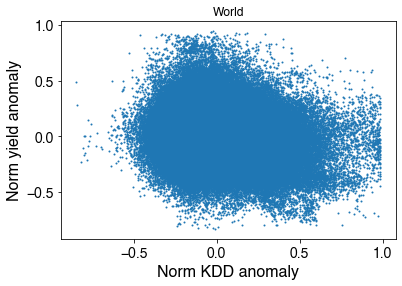

In [184]:
data = {'GDD':gddDetrend1d[maizeIndThresh], 'KDD':kddDetrend1d[maizeIndThresh], \
        'GDD2':gddDetrend1d[maizeIndThresh]**2, 'KDD2':kddDetrend1d[maizeIndThresh]**2, \
        'Yield':maizeDetrend1d[maizeIndThresh]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'GDD2', 'KDD2', \
                           'Yield'])

plt.scatter(kddDetrend1d[maizeIndThresh], maizeDetrend1d[maizeIndThresh], s=1)
plt.xlabel('Norm KDD anomaly')
plt.ylabel('Norm yield anomaly')
plt.title('World')

In [185]:
# build the FE model - the 'C' operator marks those variables as fixed effects (from R-style syntax)
mdl=smf.rlm(formula='Yield ~ GDD + KDD', data=df).fit()

In [186]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  Yield   No. Observations:               399509
Model:                            RLM   Df Residuals:                   399506
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 14 Feb 2020                                         
Time:                        17:02:39                                         
No. Iterations:                    22                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0028      0.000    -10.032      0.000      -0.003      -0.002
GDD           -0.0171      0.002     -7.712      0.000      -0.021      -0.013
KDD           -0.1395      0.002    -63.005      0.000      -0.144      -0.135
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [20]:
kddTrends1d = np.reshape(kddTrends, [kddTrends.size])
nn = np.where(~np.isnan(kddTrends1d))[0]
kddTrends1dNorm = kddTrends1d
kddTrends1dNorm[nn] = kddTrends1d[nn]/np.linalg.norm(kddTrends1d[nn])

gddTrends1d = np.reshape(gddTrends, [gddTrends.size])
nn = np.where(~np.isnan(gddTrends1d))[0]
gddTrends1dNorm = gddTrends1d
gddTrends1dNorm[nn] = gddTrends1d[nn]/np.linalg.norm(gddTrends1d[nn])

maizeTrends1d = np.reshape(maizeTrends, [maizeTrends.size])
maizeTrends1d[maizeTrends1d == 0] = np.nan
soybeanTrends1d = np.reshape(soybeanTrends, [soybeanTrends.size])
riceTrends1d = np.reshape(riceTrends, [riceTrends.size])
wheatTrends1d = np.reshape(wheatTrends, [wheatTrends.size])

In [21]:
maizeMean1d = np.reshape(np.nanmean(maize, axis=2), [maize.shape[0]*maize.shape[1]])
maizePrc50 = np.nanpercentile(maizeMean1d, 50)
maizeIndAbove50p = np.where((maizeMean1d > maizePrc50) & (~np.isnan(maizeTrends1d)) & (~np.isnan(kddTrends1d)))[0]
maizeIndBelow50p = np.where((maizeMean1d < maizePrc50) & (~np.isnan(maizeTrends1d)) & (~np.isnan(kddTrends1d)))[0]

soybeanMean1d = np.reshape(np.nanmean(soybean, axis=2), [soybean.shape[0]*soybean.shape[1]])
soybeanPrc50 = np.nanpercentile(soybeanMean1d, 50)
soybeanIndAbove50p = np.where((soybeanMean1d > soybeanPrc50) & (~np.isnan(soybeanTrends1d)) & (~np.isnan(kddTrends1d)))[0]
soybeanIndBelow50p = np.where((soybeanMean1d < soybeanPrc50) & (~np.isnan(soybeanTrends1d)) & (~np.isnan(kddTrends1d)))[0]

riceMean1d = np.reshape(np.nanmean(rice, axis=2), [rice.shape[0]*rice.shape[1]])
ricePrc50 = np.nanpercentile(riceMean1d, 50)
riceIndAbove50p = np.where((riceMean1d > ricePrc50) & (~np.isnan(riceTrends1d)) & (~np.isnan(kddTrends1d)))[0]
riceIndBelow50p = np.where((riceMean1d < ricePrc50) & (~np.isnan(riceTrends1d)) & (~np.isnan(kddTrends1d)))[0]

wheatMean1d = np.reshape(np.nanmean(wheat, axis=2), [wheat.shape[0]*wheat.shape[1]])
wheatPrc50 = np.nanpercentile(wheatMean1d, 50)
wheatIndAbove50p = np.where((wheatMean1d > wheatPrc50) & (~np.isnan(wheatTrends1d)) & (~np.isnan(kddTrends1d)))[0]
wheatIndBelow50p = np.where((wheatMean1d < wheatPrc50) & (~np.isnan(wheatTrends1d)) & (~np.isnan(kddTrends1d)))[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  Yield   No. Observations:                 1426
Model:                            RLM   Df Residuals:                     1423
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 14 Feb 2020                                         
Time:                        14:59:59                                         
No. Iterations:                    18                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1246      0.002     80.893      0.000       0.122       0.128
GDD            0.0076      0.001     11.631      0.000       0.006       0.009
KDD           -0.0144      0.001    -23.494      0.000      -0.016      -0.013
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

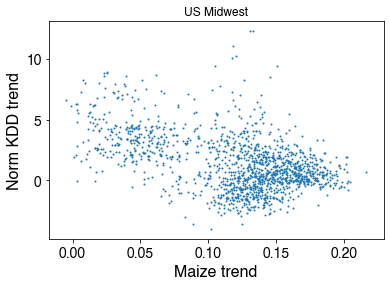

In [66]:
latUS = [30, 45]
lonUS = [-105+360, -75+360]

latIndUS = np.where((lat >= latUS[0]) & (lat <= latUS[1]))[0]
lonIndUS = np.where((lon >= lonUS[0]) & (lon <= lonUS[1]))[0]

maizeUS = maize[latIndUS, :, :]
maizeUS = maizeUS[:, lonIndUS, :]

maizeTrendsUS = maizeTrends[latIndUS, :]
maizeTrendsUS = maizeTrendsUS[:, lonIndUS]
maizeTrendsUS1d = np.reshape(maizeTrendsUS, [maizeTrendsUS.size])
maizeTrendsUS1d[maizeTrendsUS1d == 0] = np.nan

kddTrendsUS = kddTrends[latIndUS, :]
kddTrendsUS = kddTrendsUS[:, lonIndUS]
kddTrendsUS1d = np.reshape(kddTrendsUS, [kddTrendsUS.size])

gddTrendsUS = gddTrends[latIndUS, :]
gddTrendsUS = gddTrendsUS[:, lonIndUS]
gddTrendsUS1d = np.reshape(gddTrendsUS, [gddTrendsUS.size])

nn = np.where((~np.isnan(maizeTrendsUS1d)) & (~np.isnan(kddTrendsUS1d)) & (~np.isnan(gddTrendsUS1d)))[0]

plt.scatter(maizeTrendsUS1d[nn], kddTrendsUS1d[nn], s=1)
plt.xlabel('Maize trend')
plt.ylabel('Norm KDD trend')
plt.title('US Midwest')

data = {'GDD':gddTrendsUS1d[nn], 'KDD':kddTrendsUS1d[nn], \
        'GDD2':gddTrendsUS1d[nn]**2, 'KDD2':kddTrendsUS1d[nn]**2, \
        'Yield':maizeTrendsUS1d[nn]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'GDD2', 'KDD2', \
                           'Yield'])
df = df.dropna()
mdl=smf.rlm(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     5920.
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:27:05   Log-Likelihood:                 17632.
No. Observations:               43227   AIC:                        -3.526e+04
Df Residuals:                   43224   BIC:                        -3.523e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.793e-16      0.001  -6.19e-13      1.000      -0.002       0.002
GDD            0.0501      0.008      6.392      0.000       0.035       0.065
KDD           -0.5049      0.008    -64.478      0.000      -0.520      -0.490
==============================================================================
Omnibus:                      930.836   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1060.441
Skew:                          -0.323   Prob(JB):                    5.35e-231
Kurtosis:                       3.413   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

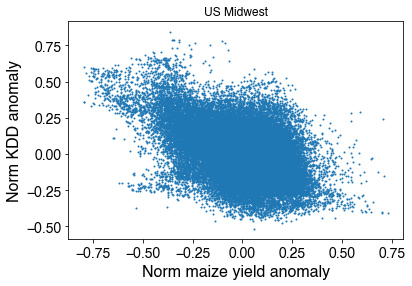

In [120]:
latUS = [30, 45]
lonUS = [-105+360, -75+360]

latIndUS = np.where((lat >= latUS[0]) & (lat <= latUS[1]))[0]
lonIndUS = np.where((lon >= lonUS[0]) & (lon <= lonUS[1]))[0]

maizeDetrendUS = maizeDetrend[latIndUS, :, :]
maizeDetrendUS = maizeDetrendUS[:, lonIndUS, :]
maizeDetrendUS1d = np.reshape(maizeDetrendUS, [maizeDetrendUS.size])

kddDetrendUS = kddDetrend[latIndUS, :, :]
kddDetrendUS = kddDetrendUS[:, lonIndUS, :]
kddDetrendUS1d = np.reshape(kddDetrendUS, [kddDetrendUS.size])

gddDetrendUS = gddDetrend[latIndUS, :]
gddDetrendUS = gddDetrendUS[:, lonIndUS]
gddDetrendUS1d = np.reshape(gddDetrendUS, [gddDetrendUS.size])

nn = np.where((~np.isnan(maizeDetrendUS1d)) & (~np.isnan(kddDetrendUS1d)) & (~np.isnan(gddDetrendUS1d)))[0]

plt.scatter(maizeDetrendUS1d[nn], kddDetrendUS1d[nn], s=1)
plt.xlabel('Norm maize yield anomaly')
plt.ylabel('Norm KDD anomaly')
plt.title('US Midwest')

data = {'GDD':gddDetrendUS1d[nn], 'KDD':kddDetrendUS1d[nn], \
        'Yield':maizeDetrendUS1d[nn]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'Yield'])
df = df.dropna()
mdl=smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     26.39
Date:                Fri, 14 Feb 2020   Prob (F-statistic):           7.04e-12
Time:                        14:12:10   Log-Likelihood:                 913.61
No. Observations:                 943   AIC:                            -1821.
Df Residuals:                     940   BIC:                            -1807.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1117      0.006     19.657      0.000       0.101       0.123
GDD            1.0302      0.959      1.075      0.283      -0.851       2.911
KDD           -8.5023      1.229     -6.916      0.000     -10.915      -6.090
==============================================================================
Omnibus:                      170.234   Durbin-Watson:                   0.389
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.667
Skew:                           1.066   Prob(JB):                     8.58e-71
Kurtosis:                       4.914   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

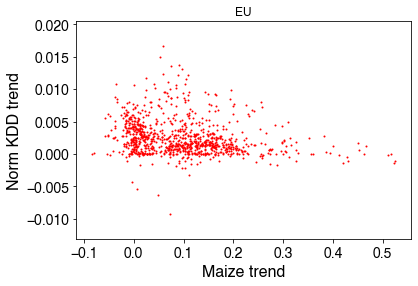

In [23]:
latEU = [30, 55]
lonEU = [-9+360, 30]

latIndEU = np.where((lat >= latEU[0]) & (lat <= latEU[1]))[0]
lonIndEU = np.where((lon >= lonEU[0]) | (lon <= lonEU[1]))[0]

maizeEU = maize[latIndEU, :, :]
maizeEU = maizeEU[:, lonIndEU, :]

maizeTrendsEU = maizeTrends[latIndEU, :]
maizeTrendsEU = maizeTrendsEU[:, lonIndEU]
maizeTrendsEU1d = np.reshape(maizeTrendsEU, [maizeTrendsEU.size])
maizeTrendsEU1d[maizeTrendsEU1d == 0] = np.nan

kddTrendsEU = kddTrends[latIndEU, :]
kddTrendsEU = kddTrendsEU[:, lonIndEU]
kddTrendsEU1d = np.reshape(kddTrendsEU, [kddTrendsEU.size])
kddTrendsEU1d[kddTrendsEU1d == 0] = np.nan

gddTrendsEU = gddTrends[latIndEU, :]
gddTrendsEU = gddTrendsEU[:, lonIndEU]
gddTrendsEU1d = np.reshape(gddTrendsEU, [gddTrendsEU.size])
gddTrendsEU1d[gddTrendsEU1d == 0] = np.nan

nn = np.where((~np.isnan(maizeTrendsEU1d)) & (~np.isnan(kddTrendsEU1d)) & (~np.isnan(gddTrendsEU1d)))[0]

plt.scatter(maizeTrendsEU1d[nn], kddTrendsEU1d[nn], color='r', s=1)
plt.xlabel('Maize trend')
plt.ylabel('Norm KDD trend')
plt.title('EU')

data = {'GDD':gddTrendsEU1d[nn], 'KDD':kddTrendsEU1d[nn], \
        'GDD2':gddTrendsEU1d[nn]**2, 'KDD2':kddTrendsEU1d[nn]**2, \
        'Yield':maizeTrendsEU1d[nn]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'GDD2', 'KDD2', \
                           'Yield'])
df = df.dropna()
mdl=smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  Yield   No. Observations:                28159
Model:                            RLM   Df Residuals:                    28156
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 14 Feb 2020                                         
Time:                        15:24:42                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0013      0.001      1.278      0.201      -0.001       0.003
GDD            0.0114      0.008      1.498      0.134      -0.004       0.026
KDD           -0.4356      0.008    -57.108      0.000      -0.451      -0.421
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

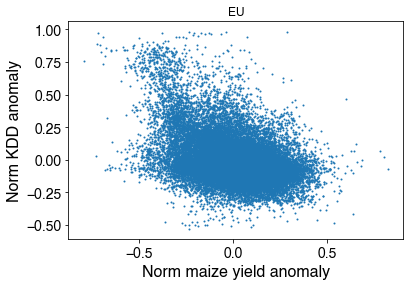

In [85]:
latEU = [30, 55]
lonEU = [-9+360, 30]

latIndEU = np.where((lat >= latEU[0]) & (lat <= latEU[1]))[0]
lonIndEU = np.where((lon >= lonEU[0]) | (lon <= lonEU[1]))[0]

maizeDetrendEU = maizeDetrend[latIndEU, :, :]
maizeDetrendEU = maizeDetrendEU[:, lonIndEU, :]
maizeDetrendEU1d = np.reshape(maizeDetrendEU, [maizeDetrendEU.size])

kddDetrendEU = kddDetrend[latIndEU, :, :]
kddDetrendEU = kddDetrendEU[:, lonIndEU, :]
kddDetrendEU1d = np.reshape(kddDetrendEU, [kddDetrendEU.size])

gddDetrendEU = gddDetrend[latIndEU, :]
gddDetrendEU = gddDetrendEU[:, lonIndEU]
gddDetrendEU1d = np.reshape(gddDetrendEU, [gddDetrendEU.size])

nn = np.where((~np.isnan(maizeDetrendEU1d)) & (~np.isnan(kddDetrendEU1d)) & (~np.isnan(gddDetrendEU1d)))[0]

plt.scatter(maizeDetrendEU1d[nn], kddDetrendEU1d[nn], s=1)
plt.xlabel('Norm maize yield anomaly')
plt.ylabel('Norm KDD anomaly')
plt.title('EU')

data = {'GDD':gddDetrendEU1d[nn], 'KDD':kddDetrendEU1d[nn], \
        'Yield':maizeDetrendEU1d[nn]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'Yield'])
df = df.dropna()
mdl=smf.rlm(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

In [24]:
nn = np.where((~np.isnan(maizeTrends1d)) & (~np.isnan(kddTrends1dNorm)) & (~np.isnan(gddTrends1dNorm)))[0]

data = {'GDD':gddTrends1dNorm[nn], 'KDD':kddTrends1dNorm[nn], \
        'Yield':maizeTrends1d[nn]}

df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'Yield'])
df = df.dropna()
mdl=smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     79.31
Date:                Fri, 14 Feb 2020   Prob (F-statistic):           5.54e-35
Time:                        14:12:11   Log-Likelihood:                 19558.
No. Observations:               14623   AIC:                        -3.911e+04
Df Residuals:                   14620   BIC:                        -3.909e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0591      0.001     95.103      0.000       0.058       0.060
GDD            1.2670      0.179      7.060      0.000       0.915       1.619
KDD            0.9277      0.175      5.298      0.000       0.584       1.271
==============================================================================
Omnibus:                     3871.073   Durbin-Watson:                   0.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16151.701
Skew:                           1.251   Prob(JB):                         0.00
Kurtosis:                       7.500   Cond. No.                         416.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""